In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

data = [
("I love this movie, it's terrible!", 0
9),
("Horrible experience, I hated it.", 0),
("Absolutely wonderful acting!", 1),
("Worst movie ever", 0),]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rajas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Preprocessing
ps = PorterStemmer ()
stop_words = set (stopwords.words('english' ))

def preprocess(text):
    tokens = word_tokenize(text. lower())
    tokens = [ps.stem(word) for word in tokens if word. isalnum() and word not in stop_words]
    return tokens
# Tokenize all texts
tokenized_data = [(preprocess(text), label) for text, label in data]
vocab = sorted(set(word for sentence,_ in tokenized_data for word in sentence))
word2idx = {word: i+1 for i, word in enumerate(vocab)} # Reserve 0 for padding
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx) + 1
print ("Sample vocabulary:", word2idx)

Sample vocabulary: {'absolut': 1, 'act': 2, 'ever': 3, 'experi': 4, 'hate': 5, 'horribl': 6, 'love': 7, 'movi': 8, 'terribl': 9, 'wonder': 10, 'worst': 11}


In [24]:
from torch.nn.utils.rnn import pad_sequence

def encode_sentence(sentence):
  return torch.tensor([word2idx[word] for word in sentence], dtype=torch.long)

# Encode and pad
encoded_sentences = [encode_sentence(s) for s, _ in tokenized_data]
labels = torch.tensor([label for _, label in tokenized_data])

padded_sentences = pad_sequence(encoded_sentences, batch_first=True)
print("Padded input shape:", padded_sentences.shape)

Padded input shape: torch.Size([4, 3])


In [25]:
class RNNClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 2)

  def forward(self,x):
    embedded = self.embed(x)
    output, hidden = self.rnn(embedded)
    return self.fc(hidden.squeeze(0))

Epoch 1: Loss = 0.8223
Epoch 2: Loss = 0.5359
Epoch 3: Loss = 0.3382
Epoch 4: Loss = 0.2008
Epoch 5: Loss = 0.1121
Epoch 6: Loss = 0.0604
Epoch 7: Loss = 0.0327
Epoch 8: Loss = 0.0182
Epoch 9: Loss = 0.0107
Epoch 10: Loss = 0.0066
Epoch 11: Loss = 0.0043
Epoch 12: Loss = 0.0029
Epoch 13: Loss = 0.0021
Epoch 14: Loss = 0.0015
Epoch 15: Loss = 0.0012
Epoch 16: Loss = 0.0009
Epoch 17: Loss = 0.0007
Epoch 18: Loss = 0.0006
Epoch 19: Loss = 0.0005
Epoch 20: Loss = 0.0004


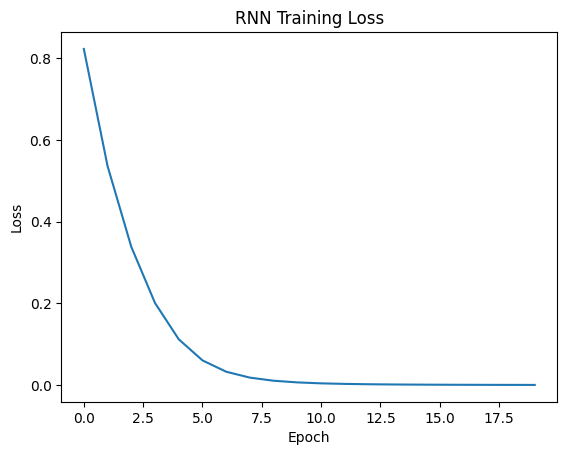

In [26]:
def train_model (model, X, y, epochs=20):
  optimizer = optim. Adam(model.parameters(), lr=0.01)
  loss_fn = nn.CrossEntropyLoss()
  losses = []

  for epoch in range(epochs) :
    model. train()
    optimizer.zero_grad()
    output = model (X)
    loss = loss_fn(output, y)
    loss.backward()
    optimizer. step()
    losses.append(loss. item ( ))
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
  
  # Plot loss
  plt.plot(losses)
  plt.title("RNN Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  return model

rnn_model = RNNClassifier(vocab_size, embed_dim=16, hidden_dim=32)
trained_rnn = train_model(rnn_model, padded_sentences, labels)

In [27]:
def predict(model, sentence):
  model.eval()
  tokens = preprocess(sentence)
  input_tensor = encode_sentence(tokens).unsqueeze(0)
  with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()
  return "Positive" if pred == 1 else "Negative"

print(predict(trained_rnn, "What a wonderful movie"))
print(predict(trained_rnn, "This was terrible"))

Positive
Negative
